In [246]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report

In [287]:
data = load_iris()['data']
label = load_iris()['target']
data = data[label!=1]
label = label[label != 1]
label = np.array([1 if i == 2 else -1 for i in label])

In [288]:
class AdaBoost:
    def __init__(self, 
                 steps=10,
                 iters=100):
        self.steps = steps
        self.iters = iters
    
    def pred_value(self, data, dim, threadvalue, thread_dirct):
        m,n = data.shape
        preds = np.ones((m, 1))
        if thread_dirct == 'lt':
            preds[data[:, dim] <= threadvalue] = -1.0
        else:
            preds[data[:, dim] > threadvalue] = -1.0
        return preds

    def base_model(self, data, label, D):
        m, n = data.shape
        numsteps = self.steps
        beststump = {}
        minerr = np.inf
    
        for i in range(n):
            minvalue, maxvalue = data[:, i].min(), data[:, i].max()
            step = (maxvalue - minvalue) / numsteps
            #print(step)
            for j in range(1, int(numsteps)+1):
                for k in ['lt', 'rh']:
                    threadvalues = minvalue + j * step
                    preds = pred_value(data, i, threadvalues, k)
                
                    errarr = np.ones((m, 1))
                    errarr[preds.flatten() == label] = 0 
                    # 构造一个误差矩阵，当不相等时 为1 否则为1。
                    weight_err = np.dot(D.T, errarr)[0][0]
                #print("dim={},weighterr={},thread={},dir={}".format(i,weight_err,threadvalues,k))
                    if weight_err < minerr:
                        minerr = weight_err
                        beststump['bestclass'] = preds #.copy()
                        beststump['best_dim'] = i
                        beststump['best_threadvalue'] = threadvalues
                        beststump['best_dir'] = k
                        beststump['min_err'] = minerr
                    #print("best_dim={},minerr={},best_thread={},best_dir={}".format(i,minerr,threadvalue,k))
        return beststump

    def adaboost(self, data, label): # iters 决定弱分类器的个数
        m, n = data.shape
        D = np.ones((m, 1)) / m
        model_agg = []
        aggclassest = np.zeros((m, 1))
    
        i = 0
        while i < self.iters:
            i += 1
            bestmodel = self.base_model(data, label, D)
            model_agg.append(bestmodel)
        
            err = bestmodel['min_err']
            print("iters {}, err is {}".format(i, err))
            alpha = 0.5 * np.log((1.0 - err) / max(err, 0.001))
            bestmodel['alphas'] = alpha
    
            preds = bestmodel['bestclass']
            temp = -1 * np.multiply(np.multiply(alpha, label.T), preds)
            mid = np.multiply(D, np.exp(temp))
            D = mid / sum(mid)
        
            aggclassest += np.multiply(alpha, preds)
            aggerrors = np.sum(np.sign(aggclassest.flatten()) != label)
            errrate = aggerrors / m
            if errrate < 0.001:
                break
        return model_agg

    @staticmethod
    def adaclassify(data, classifierArr, label):
        m = data.shape[0]
        aggclassset = np.zeros((m, 1))
        for i in range(len(classifierArr)):
            preds = pred_value(data, classifierArr[i]['best_dim'], classifierArr[i]['best_threadvalue'],classifierArr[i]['best_dir'])
            aggclassset += np.multiply(classifierArr[i]['alphas'], preds)
        #print(aggclassset)
        last_pred = np.sign(aggclassset)
        err = np.sum((last_pred != label)) / m
        return aggclassset,last_pred, err

In [289]:
mymodel = AdaBoost()

In [290]:
models = mymodel.adaboost(data, label)
agg_pred, last_pred, b = mymodel.adaclassify(data, models, label)
print(classification_report(label, re['last_preds'][0].flatten()))

iters 1, err is 0.0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



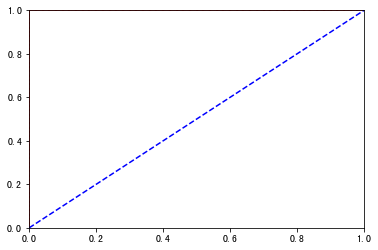

the area under the cureve is : 1.0


In [291]:
def plot_roc(preds, classlabels):
    import matplotlib.pyplot as plt
    cur = (1.0, 1.0)
    ySum = 0.
    numPosClas = sum(classlabels == 1.0)
    yStep = 1 / float(numPosClas)
    xStep = 1 / float(len(classlabels)-numPosClas)
    
    temps = preds.reshape(-1)
    sortedindices = temps.argsort()
    
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(1,1,1)
    
    for index in sortedindices:
        if classlabels[index]==1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY],c='r')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    ax.axis([0,1,0,1])
    plt.show()
    print("the area under the cureve is :",ySum * xStep)
    
# modelss, predss = (data,label)
plot_roc(last_pred,label)

In [266]:
#temp = predss.A.reshape(-1)
#xx = temp.argsort()

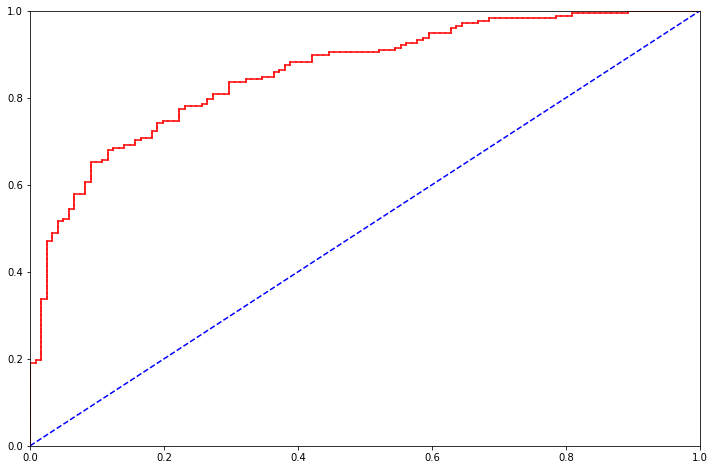

the area under the cureve is : 0.8568576469495774


In [165]:
import matplotlib.pyplot as plt
cur = (1.0,1.0)
ySum = 0.
numPosClas = sum(array(tl)==1.0)
yStep = 1/float(numPosClas)
xStep = 1/float(len(tl)-numPosClas)
    
temps = predss.A.reshape(-1)
sds = temps.argsort()
    
fig = plt.figure(figsize=(12,8))
fig.clf()
ax = plt.subplot(1,1,1)
    
for index in sds:
    #print(index)
    if tl[index]==1.0:
        delX = 0
        delY = yStep
    else:
        delX = xStep
        delY = 0
        ySum += cur[1]
    ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY],c='r')
    cur = (cur[0]-delX,cur[1]-delY)
ax.plot([0,1],[0,1],'b--')
ax.axis([0,1,0,1])
plt.show()
print("the area under the cureve is :",ySum * xStep)